In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import time

from torchvision import datasets   # Mnist dataset을 불러오기 위해서
import torchvision.transforms as transforms  # 전처리를 위한 라이브러리
from torchvision.utils import save_image

In [81]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print(DEVICE)

cuda


In [88]:
transforms_set = transforms.Compose([transforms.Resize(32), transforms.ToTensor(), transforms.Normalize([0.5],[0.5])])

#train_dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=transforms_set)
train_dataset = datasets.CIFAR10(root="./data/CIFAR_10", train=True, download=True, transform = transforms_set)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle=True, num_workers=4)

Files already downloaded and verified


In [89]:
latent_dim = 100 # latent vector를 뽑기 위한 노이즈 분포의 dimention|

In [90]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        def block(input_dim, output_dim, normalize=True):
            layers = [nn.Linear(input_dim, output_dim)]
            if normalize:  # 배치 정규화 수행(차원동일)
                layers.append(nn.BatchNorm1d(output_dim, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
                
        self.model = nn.Sequential(*block(latent_dim,128,normalize=False),
                                  *block(128,256), *block(256,512),*block(512,1024),
                                  nn.Linear(1024,3*32*32), nn.Tanh())
        
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 3,32,32)
        return img
    

In [91]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(nn.Linear(3*32*32,512),
                                  nn.LeakyReLU(0.2, inplace=True),
                                  nn.Linear(512,256),
                                  nn.LeakyReLU(0.2,inplace=True),
                                  nn.Linear(256,1),
                                  nn.Sigmoid(),)
        
    def forward(self, img):
        flattend = img.view(img.size(0),-1)
        output = self.model(flattend)
        
        return output
        

In [92]:
generator = Generator().to(DEVICE)
discriminator = Discriminator().to(DEVICE)

# loss function
adversarial_loss = nn.BCELoss()
adversarial_loss.to(DEVICE)

# learning rate
lr = 0.0002

#optimizer 
optimizer_G = torch.optim.Adam(generator.parameters(),lr=lr, betas=(0.5,0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [94]:

n_epochs = 100 # 학습의 횟수(epoch) 설정
sample_interval = 2000 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성
        real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0) # 가짜(fake): 0

        real_imgs = imgs.cuda()

        """ 생성자(generator)를 학습합니다. """
        optimizer_G.zero_grad()

        # 랜덤 노이즈(noise) 샘플링
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()

        # 이미지 생성
        generated_imgs = generator(z)

        # 생성자(generator)의 손실(loss) 값 계산
        g_loss = adversarial_loss(discriminator(generated_imgs), real)

        # 생성자(generator) 업데이트
        g_loss.backward()
        optimizer_G.step()

        """ 판별자(discriminator)를 학습합니다. """
        optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 계산
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 판별자(discriminator) 업데이트
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            # 생성된 이미지 중에서 25개만 선택하여 5 X 5 격자 이미지에 출력
            save_image(generated_imgs.data[:25], f"{done}.png", nrow=5, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")
     

[Epoch 0/100] [D loss: 0.663049] [G loss: 1.210755] [Elapsed time: 31.60s]
[Epoch 1/100] [D loss: 0.464966] [G loss: 1.253403] [Elapsed time: 63.10s]
[Epoch 2/100] [D loss: 0.604617] [G loss: 1.016894] [Elapsed time: 95.46s]
[Epoch 3/100] [D loss: 0.509989] [G loss: 1.164173] [Elapsed time: 127.32s]
[Epoch 4/100] [D loss: 0.431305] [G loss: 1.315345] [Elapsed time: 158.87s]
[Epoch 5/100] [D loss: 0.346768] [G loss: 1.187740] [Elapsed time: 190.48s]
[Epoch 6/100] [D loss: 0.441009] [G loss: 1.416542] [Elapsed time: 221.97s]
[Epoch 7/100] [D loss: 0.476753] [G loss: 1.307449] [Elapsed time: 253.48s]
[Epoch 8/100] [D loss: 0.440001] [G loss: 1.537471] [Elapsed time: 285.04s]
[Epoch 9/100] [D loss: 0.454565] [G loss: 1.289033] [Elapsed time: 316.85s]
[Epoch 10/100] [D loss: 0.573435] [G loss: 1.110513] [Elapsed time: 348.37s]
[Epoch 11/100] [D loss: 0.542261] [G loss: 1.053087] [Elapsed time: 380.10s]
[Epoch 12/100] [D loss: 0.504957] [G loss: 1.119048] [Elapsed time: 412.70s]
[Epoch 13/10

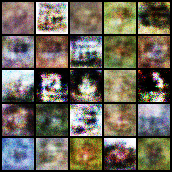

In [96]:
from IPython.display import Image
Image('38000.png')